# Supervised R-HMM segmentation

## Init

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from collections import OrderedDict
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, accuracy_score
import datetime as dt
from scipy import signal
import os
from pathlib import Path
from tqdm.auto import trange

In [2]:
from segmentation_utils import (
    extract_eef_data_from_rosbag,
    get_ground_truth_segmentation,
)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pyro
import pyro.distributions as dist
from pyro.infer import autoguide
from pyro.infer import Predictive
from pyro.nn import PyroModule

In [4]:
# pyro.set_rng_seed(1)
pyro.clear_param_store()

In [5]:
# %matplotlib ipympl
%load_ext autoreload
%autoreload 2

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


## Data files

In [7]:
data_path_root = Path("../table-task-ur5e")
data_path_root.exists()

True

In [8]:
bagfiles = list(data_path_root.glob("*.bag"))
bagfiles

[PosixPath('../table-task-ur5e/rosbag2_2025-08-05_21-08-23_2025-08-05-21-08-23.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-08-05_21-33-31_2025-08-05-21-33-31.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-08-05_21-36-29_2025-08-05-21-36-29.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-08-05_21-43-41_2025-08-05-21-43-41.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-09-04_18-10-23_2025-09-04-18-10-23_test-image.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-09-08_16-33-22_2025-09-08-16-33-23.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-09-08_16-35-57_2025-09-08-16-35-57.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-09-08_16-53-14_2025-09-08-16-53-14_okayish.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-09-08_19-43-25_2025-09-08-19-43-25.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-09-08_19-46-18_2025-09-08-19-46-19.bag')]

In [9]:
filenum = -1
bagfile = bagfiles[filenum]
bagfile

PosixPath('../table-task-ur5e/rosbag2_2025-09-08_19-46-18_2025-09-08-19-46-19.bag')

In [10]:
ground_truth_segm_file = data_path_root / "table_task_UR5e_ground_truth.json"
ground_truth_segm_file.exists()

True

## Preprocessing

In [11]:
traj = extract_eef_data_from_rosbag(bagfile)
traj

Extracting TF & gripper data from Bag file...


  0%|          | 0/183488 [00:00<?, ?it/s]

Extracting TF & gripper data from Bag file: done ✓


,x,y,z,timestamp,gripper
0,-0.057518,-0.349359,0.245916,2025-09-08 18:46:19.430824291-05:00,0.01
1,-0.057527,-0.349371,0.245943,2025-09-08 18:46:19.432620296-05:00,0.01
2,-0.057521,-0.349371,0.245940,2025-09-08 18:46:19.434438816-05:00,0.01
3,-0.057525,-0.349373,0.245945,2025-09-08 18:46:19.436862995-05:00,0.01
4,-0.057515,-0.349382,0.245951,2025-09-08 18:46:19.438580443-05:00,0.01
...,...,...,...,...,...
57561,-0.079063,-0.339990,0.226383,2025-09-08 18:48:14.634462638-05:00,0.01
57562,-0.079040,-0.339984,0.226385,2025-09-08 18:48:14.636379567-05:00,0.01
57563,-0.079073,-0.339983,0.226388,2025-09-08 18:48:14.638744970-05:00,0.01
57564,-0.079063,-0.339978,0.226381,2025-09-08 18:48:14.640788775-05:00,0.01


In [12]:
df = traj.diff().mean().timestamp.total_seconds()
df

0.002001

In [13]:
# downsampling = 10

In [14]:
# freq = 1 / (df * downsampling)
# freq

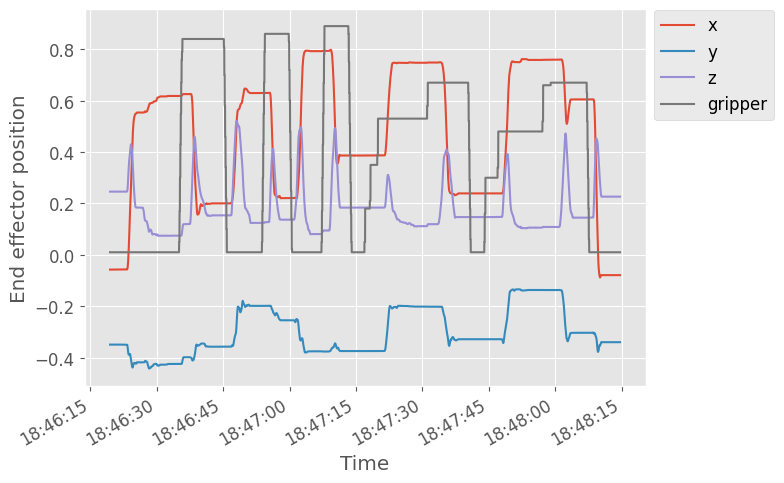

In [15]:
with plt.style.context("ggplot_perso.mplstyle"):
    # with plt.style.context("ggplot"):
    fig, ax = plt.subplots(figsize=(8, 5))
    # cmap = mpl.colormaps.get("tab10").colors
    ax.plot(traj.timestamp, traj.x, label="x")  # , color=cmap[0])
    ax.plot(traj.timestamp, traj.y, label="y")  # , color=cmap[1])
    ax.plot(traj.timestamp, traj.z, label="z")  # , color=cmap[2])
    ax.plot(traj.timestamp, traj.gripper, label="gripper")  # , color=cmap[3])
    ax.set_xlabel("Time")
    ax.set_ylabel("End effector position")
    # ax.legend(loc="best")
    ax.legend(bbox_to_anchor=(1.0, 1.02))
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()

## Ground truth segmentation

In [16]:
gt_segm_dict = get_ground_truth_segmentation(
    ground_truth_segm_file=ground_truth_segm_file, bagfile=bagfile
)
gt_segm_dict

{'filename': 'rosbag2_2025-09-08_19-46-18_2025-09-08-19-46-19.bag',
 'HigherLevel': {'plate': {'ini': 1757375183, 'end': 1757375205},
  'cup': {'ini': 1757375207, 'end': 1757375220},
  'napkin': {'ini': 1757375220, 'end': 1757375232},
  'spoon': {'ini': 1757375235, 'end': 1757375258},
  'fork': {'ini': 1757375262, 'end': 1757375288}},
 'LowerLevel': {'reaching': [{'ini': 1757375183, 'end': 1757375194},
   {'ini': 1757375207, 'end': 1757375212},
   {'ini': 1757375220, 'end': 1757375226},
   {'ini': 1757375235, 'end': 1757375253},
   {'ini': 1757375262, 'end': 1757375280}],
  'placing': [{'ini': 1757375197, 'end': 1757375205},
   {'ini': 1757375215, 'end': 1757375220},
   {'ini': 1757375228, 'end': 1757375232},
   {'ini': 1757375253, 'end': 1757375258},
   {'ini': 1757375280, 'end': 1757375288}]}}

### Higher level movements

In [17]:
# with plt.style.context("ggplot_perso.mplstyle"):
#     fig, ax = plt.subplots(figsize=(11, 7))
#     cmap = mpl.colormaps.get("Pastel2").colors
#     ax.plot(traj.timestamp, traj.x, label="x")  # , color=cmap[0])
#     ax.plot(traj.timestamp, traj.y, label="y")  # , color=cmap[1])
#     ax.plot(traj.timestamp, traj.z, label="z")  # , color=cmap[2])
#     ax.plot(traj.timestamp, traj.gripper, label="gripper")  # , color=cmap[3])

#     fill_min = np.min([traj.x.min(), traj.y.min(), traj.z.min(), traj.gripper.min()])
#     fill_max = np.max([traj.x.max(), traj.y.max(), traj.z.max(), traj.gripper.max()])
#     for sect_i, sect_key in enumerate(gt_segm_dict["HigherLevel"].keys()):
#         sect_dict_current = gt_segm_dict["HigherLevel"][sect_key]
#         xs = traj.timestamp[
#             (
#                 traj.timestamp
#                 > pd.Timestamp(
#                     dt.datetime.fromtimestamp(sect_dict_current["ini"])
#                     - dt.timedelta(hours=1),
#                     tz="EST",
#                 )
#             )
#             & (
#                 traj.timestamp
#                 < pd.Timestamp(
#                     dt.datetime.fromtimestamp(sect_dict_current["end"])
#                     - dt.timedelta(hours=1),
#                     tz="EST",
#                 )
#             )
#         ]  # - dt.timedelta(hours=5)
#         ax.fill_between(
#             x=xs,
#             y1=fill_min - 1,
#             y2=fill_max + 1,
#             color=cmap[sect_i],
#             alpha=0.5,
#             transform=ax.get_xaxis_transform(),
#             label=sect_key,
#         )

#     ax.set_ylim(bottom=fill_min - 0.1, top=fill_max + 0.1)
#     ax.set_xlabel("Time")
#     ax.set_ylabel("End effector position")
#     ax.legend(bbox_to_anchor=(1.0, 1.02))
#     ax.set_title("Ground truth clustering")
#     fig.autofmt_xdate()
#     fig.tight_layout()
#     plt.show()

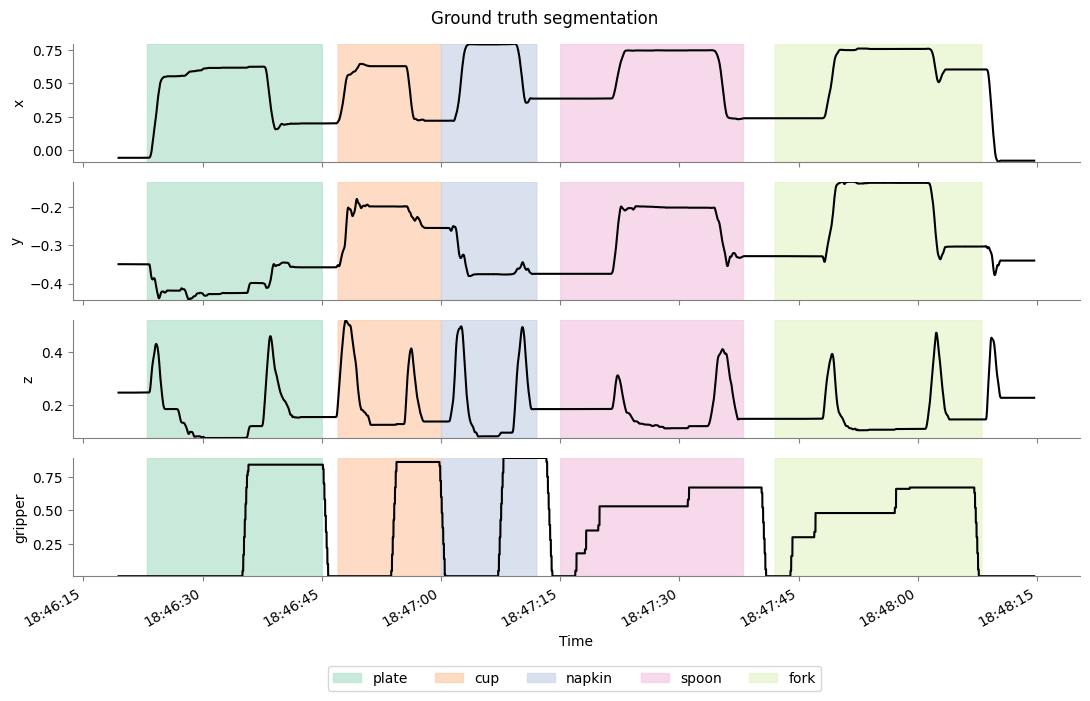

In [18]:
df_labels = list(traj.drop(columns=["timestamp"]).keys())
fig, axes = plt.subplots(
    nrows=len(df_labels), ncols=1, sharex=True, sharey=False, figsize=(11, 7)
)
cmap = mpl.colormaps.get("Pastel2").colors
for idx, ax in enumerate(axes):
    ax.plot(traj.timestamp, traj[df_labels[idx]], "k")
    ax.set_ylabel(df_labels[idx])
    ax.spines[["right", "top"]].set_visible(False)

    y_low = traj[df_labels[idx]].min()
    y_high = traj[df_labels[idx]].max()
    ax.set_ylim(bottom=y_low, top=y_high)
    ax.tick_params(color="gray")
    for spine in ax.spines.values():
        spine.set_edgecolor("gray")

    for sect_i, sect_key in enumerate(gt_segm_dict["HigherLevel"].keys()):
        sect_dict_current = gt_segm_dict["HigherLevel"][sect_key]
        xs = traj.timestamp[
            (
                traj.timestamp
                > pd.Timestamp(
                    dt.datetime.fromtimestamp(sect_dict_current["ini"])
                    - dt.timedelta(hours=1),
                    tz="EST",
                )
            )
            & (
                traj.timestamp
                < pd.Timestamp(
                    dt.datetime.fromtimestamp(sect_dict_current["end"])
                    - dt.timedelta(hours=1),
                    tz="EST",
                )
            )
        ]  # - dt.timedelta(hours=5)
        ax.fill_between(
            x=xs,
            y1=y_low,
            y2=y_high,
            color=cmap[sect_i],
            alpha=0.7,
            # transform=ax.get_xaxis_transform(),
            label=sect_key,
        )

axes[-1].set_xlabel("Time")
# axes[0].legend(bbox_to_anchor=(1.0, 1.02))
axes[-1].legend(
    bbox_to_anchor=(0.75, -0.7), ncol=len(gt_segm_dict["HigherLevel"].keys())
)
fig.suptitle("Ground truth segmentation")
fig.autofmt_xdate()
fig.tight_layout()
plt.show()

### Lower level movements

In [19]:
# with plt.style.context("ggplot_perso.mplstyle"):
#     fig, ax = plt.subplots(figsize=(11, 7))
#     cmap = mpl.colormaps.get("Pastel2").colors
#     ax.plot(traj.timestamp, traj.x, label="x")  # , color=cmap[0])
#     ax.plot(traj.timestamp, traj.y, label="y")  # , color=cmap[1])
#     ax.plot(traj.timestamp, traj.z, label="z")  # , color=cmap[2])
#     ax.plot(traj.timestamp, traj.gripper, label="gripper")  # , color=cmap[3])

#     fill_min = np.min([traj.x.min(), traj.y.min(), traj.z.min(), traj.gripper.min()])
#     fill_max = np.max([traj.x.max(), traj.y.max(), traj.z.max(), traj.gripper.max()])
#     for sect_i, sect_key in enumerate(gt_segm_dict["LowerLevel"].keys()):
#         skill_current = gt_segm_dict["LowerLevel"][sect_key]
#         for skill_i, skill_val in enumerate(skill_current):
#             xs = traj.timestamp[
#                 (
#                     traj.timestamp
#                     > pd.Timestamp(
#                         dt.datetime.fromtimestamp(skill_val["ini"])
#                         - dt.timedelta(hours=1),
#                         tz="EST",
#                     )
#                 )
#                 & (
#                     traj.timestamp
#                     < pd.Timestamp(
#                         dt.datetime.fromtimestamp(skill_val["end"])
#                         - dt.timedelta(hours=1),
#                         tz="EST",
#                     )
#                 )
#             ]  # - dt.timedelta(hours=5)
#             if skill_i == 0:
#                 ax.fill_between(
#                     x=xs,
#                     y1=fill_min - 1,
#                     y2=fill_max + 1,
#                     color=cmap[sect_i],
#                     alpha=0.5,
#                     transform=ax.get_xaxis_transform(),
#                     label=sect_key,
#                 )
#             else:
#                 ax.fill_between(
#                     x=xs,
#                     y1=fill_min - 1,
#                     y2=fill_max + 1,
#                     color=cmap[sect_i],
#                     alpha=0.5,
#                     transform=ax.get_xaxis_transform(),
#                     # label=sect_key,
#                 )

#     ax.set_ylim(bottom=fill_min - 0.1, top=fill_max + 0.1)
#     ax.set_xlabel("Time")
#     ax.set_ylabel("End effector position")
#     ax.legend(bbox_to_anchor=(1.0, 1.02))
#     ax.set_title("Ground truth clustering")
#     fig.autofmt_xdate()
#     fig.tight_layout()
#     plt.show()

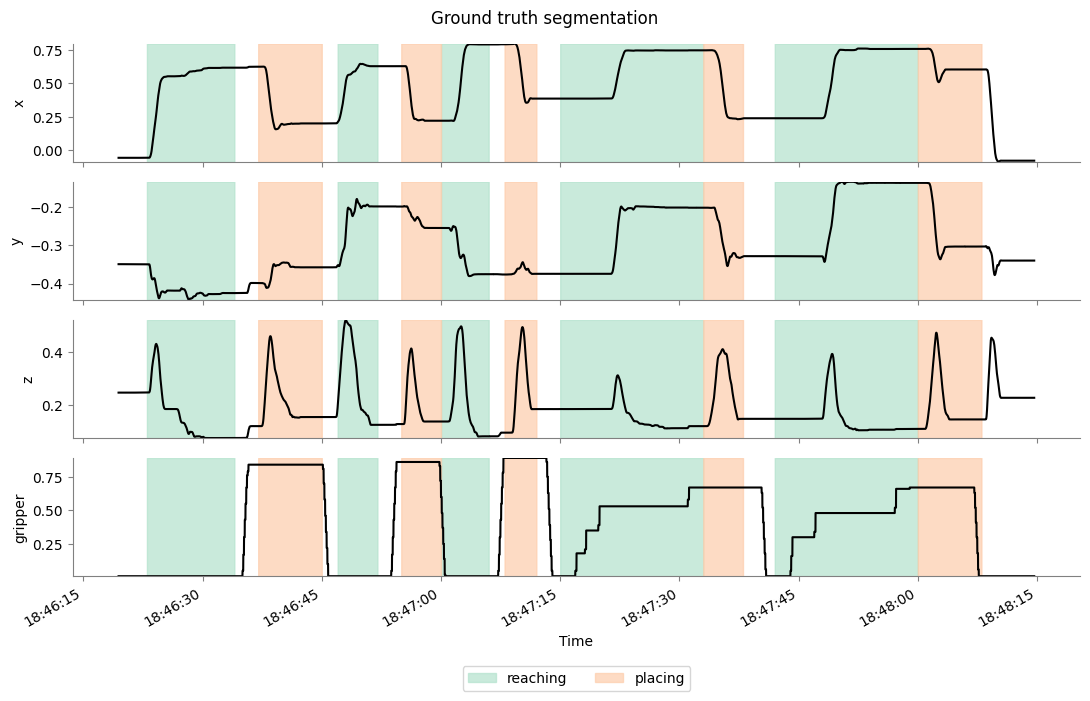

In [20]:
df_labels = list(traj.drop(columns=["timestamp"]).keys())
fig, axes = plt.subplots(
    nrows=len(df_labels), ncols=1, sharex=True, sharey=False, figsize=(11, 7)
)
cmap = mpl.colormaps.get("Pastel2").colors
for idx, ax in enumerate(axes):
    ax.plot(traj.timestamp, traj[df_labels[idx]], "k")
    ax.set_ylabel(df_labels[idx])
    ax.spines[["right", "top"]].set_visible(False)

    y_low = traj[df_labels[idx]].min()
    y_high = traj[df_labels[idx]].max()
    ax.set_ylim(bottom=y_low, top=y_high)
    ax.tick_params(color="gray")
    for spine in ax.spines.values():
        spine.set_edgecolor("gray")

    for sect_i, sect_key in enumerate(gt_segm_dict["LowerLevel"].keys()):
        skill_current = gt_segm_dict["LowerLevel"][sect_key]
        for skill_i, skill_val in enumerate(skill_current):
            xs = traj.timestamp[
                (
                    traj.timestamp
                    > pd.Timestamp(
                        dt.datetime.fromtimestamp(skill_val["ini"])
                        - dt.timedelta(hours=1),
                        tz="EST",
                    )
                )
                & (
                    traj.timestamp
                    < pd.Timestamp(
                        dt.datetime.fromtimestamp(skill_val["end"])
                        - dt.timedelta(hours=1),
                        tz="EST",
                    )
                )
            ]  # - dt.timedelta(hours=5)
            if skill_i == 0:
                ax.fill_between(
                    x=xs,
                    y1=y_low,
                    y2=y_high,
                    color=cmap[sect_i],
                    alpha=0.7,
                    # transform=ax.get_xaxis_transform(),
                    label=sect_key,
                )
            else:
                ax.fill_between(
                    x=xs,
                    y1=y_low,
                    y2=y_high,
                    color=cmap[sect_i],
                    alpha=0.7,
                    # transform=ax.get_xaxis_transform(),
                )

axes[-1].set_xlabel("Time")
# axes[0].legend(bbox_to_anchor=(1.0, 1.02))
axes[-1].legend(
    bbox_to_anchor=(0.62, -0.7), ncol=len(gt_segm_dict["LowerLevel"].keys())
)
fig.suptitle("Ground truth segmentation")
fig.autofmt_xdate()
fig.tight_layout()
plt.show()

## Segmentation

### Hyperparameters

In [21]:
downsampling_factor = 200

In [22]:
# what_segments = "HigherLevel"
what_segments = "LowerLevel"

labels = gt_segm_dict[what_segments].keys()
labels

dict_keys(['reaching', 'placing'])

In [23]:
# RNN parameters
# rnn_hidden_size = 32
rnn_hidden_size = 4

In [24]:
num_epochs = 1000
num_samples_posterior = 500
learning_rate = 1e-3
rnn_num_layers = 1

### Preprocessing

In [25]:
# true_cps = np.ones((len(gt_segm_dict["HigherLevel"]) - 1)) * np.nan
# for sect_i, sect_key in enumerate(gt_segm_dict["HigherLevel"].keys()):
#     sect_dict_current = gt_segm_dict["HigherLevel"][sect_key]
#     if sect_i < len(true_cps):
#         true_cps[sect_i] = sect_dict_current["end"]
# true_cps

In [26]:
X = traj.drop(columns=["timestamp"])
X

,x,y,z,gripper
0,-0.057518,-0.349359,0.245916,0.01
1,-0.057527,-0.349371,0.245943,0.01
2,-0.057521,-0.349371,0.245940,0.01
3,-0.057525,-0.349373,0.245945,0.01
4,-0.057515,-0.349382,0.245951,0.01
...,...,...,...,...
57561,-0.079063,-0.339990,0.226383,0.01
57562,-0.079040,-0.339984,0.226385,0.01
57563,-0.079073,-0.339983,0.226388,0.01
57564,-0.079063,-0.339978,0.226381,0.01


In [27]:
def get_closest_ts(traj_ts, query_idx):
    idx2ts = pd.Timestamp(
        dt.datetime.fromtimestamp(query_idx) - dt.timedelta(hours=1),
        tz="EST",
    )
    closest_tdelta = (traj_ts - idx2ts).abs().min()
    idx_res = traj_ts.index[traj_ts == closest_tdelta + idx2ts]
    return idx_res[0]

In [28]:
# Create supervised labels
y = np.ones(shape=X.shape[0]) * np.nan
if what_segments == "HigherLevel":
    for sect_i, sect_key in enumerate(gt_segm_dict[what_segments].keys()):
        sect_dict_current = gt_segm_dict[what_segments][sect_key]
        idx_ini = get_closest_ts(
            traj_ts=traj.timestamp, query_idx=sect_dict_current["ini"]
        )
        idx_end = get_closest_ts(
            traj_ts=traj.timestamp, query_idx=sect_dict_current["end"]
        )
        y[idx_ini:idx_end] = sect_i

elif what_segments == "LowerLevel":
    for sect_i, sect_key in enumerate(gt_segm_dict[what_segments].keys()):
        skill_current = gt_segm_dict[what_segments][sect_key]
        for skill_i, skill_val in enumerate(skill_current):
            idx_ini = get_closest_ts(traj_ts=traj.timestamp, query_idx=skill_val["ini"])
            idx_end = get_closest_ts(traj_ts=traj.timestamp, query_idx=skill_val["end"])
            y[idx_ini:idx_end] = sect_i

else:
    raise ValueError("what_segments can only be 'HigherLevel' or 'LowerLevel'")
y

array([nan, nan, nan, ..., nan, nan, nan], shape=(57566,))

In [29]:
np.unique(y)

array([ 0.,  1., nan])

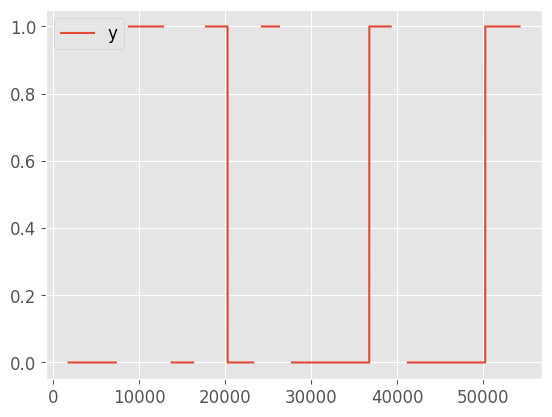

In [30]:
with plt.style.context("ggplot_perso.mplstyle"):
    fig, ax = plt.subplots()  # figsize=(11, 7))
    ax.plot(y, label="y")
    ax.legend(loc="best")
    plt.show()

In [31]:
idx2filter = np.where(~np.isnan(y))
idx2filter

(array([ 1785,  1786,  1787, ..., 54243, 54244, 54245], shape=(43966,)),)

In [32]:
y_filtered = y[idx2filter]
y_filtered

array([0., 0., 0., ..., 1., 1., 1.], shape=(43966,))

In [33]:
np.unique(y_filtered)

array([0., 1.])

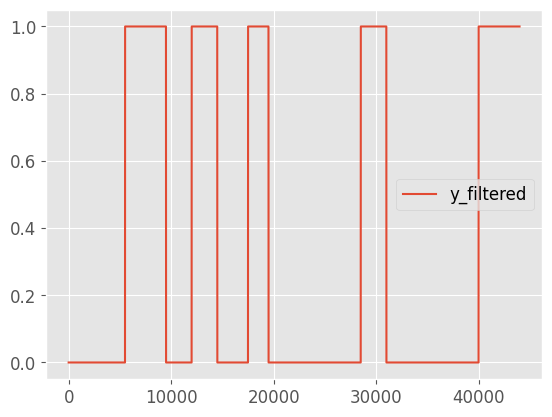

In [34]:
with plt.style.context("ggplot_perso.mplstyle"):
    fig, ax = plt.subplots()  # figsize=(11, 7))
    ax.plot(y_filtered, label="y_filtered")
    ax.legend(loc="best")
    plt.show()

In [35]:
X_filtered = X.iloc[idx2filter]
X_filtered

,x,y,z,gripper
1785,-0.057529,-0.349365,0.245910,0.01
1786,-0.057517,-0.349362,0.245916,0.01
1787,-0.057519,-0.349371,0.245965,0.01
1788,-0.057496,-0.349364,0.245927,0.01
1789,-0.057527,-0.349372,0.245934,0.01
...,...,...,...,...
54241,0.604773,-0.303366,0.144645,0.01
54242,0.604773,-0.303355,0.144652,0.01
54243,0.604772,-0.303351,0.144637,0.01
54244,0.604767,-0.303379,0.144689,0.01


In [36]:
X_scaled = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_filtered)
X_scaled

array([[2.03462542e-05, 3.02970248e-01, 3.84556711e-01, 0.00000000e+00],
       [3.37339936e-05, 3.02978356e-01, 3.84570559e-01, 0.00000000e+00],
       [3.12934476e-05, 3.02949718e-01, 3.84679761e-01, 0.00000000e+00],
       ...,
       [7.73938439e-01, 4.52026190e-01, 1.57855692e-01, 0.00000000e+00],
       [7.73931971e-01, 4.51937085e-01, 1.57972680e-01, 0.00000000e+00],
       [7.73951043e-01, 4.51959832e-01, 1.57998140e-01, 0.00000000e+00]],
      shape=(43966, 4))

In [37]:
X_down = signal.decimate(x=X_filtered, q=downsampling_factor, axis=0)
X_down.shape

(220, 4)

In [38]:
minmaxscaler = MinMaxScaler(feature_range=(0, 1))
X_down_scaled = minmaxscaler.fit_transform(X_down)
X_down_scaled.shape

(220, 4)

In [39]:
np.any(np.isinf(X_down_scaled)), np.any(np.isnan(X_down_scaled))

(np.False_, np.False_)

In [40]:
y_down = np.round(signal.decimate(x=y_filtered, q=downsampling_factor, axis=0)).astype(
    int
)
y_down

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [41]:
np.unique(y_down)

array([0, 1])

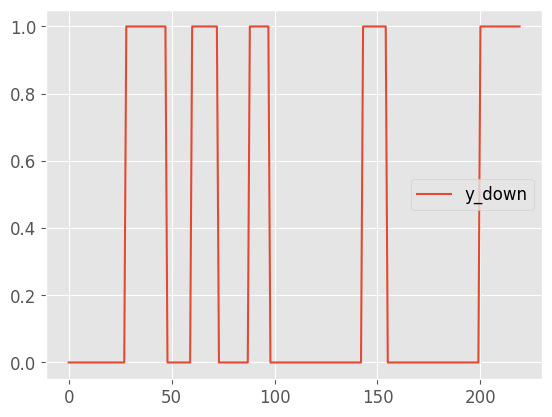

In [42]:
with plt.style.context("ggplot_perso.mplstyle"):
    fig, ax = plt.subplots()  # figsize=(11, 7))
    ax.plot(y_down, label="y_down")
    ax.legend(loc="best")
    plt.show()

In [43]:
# timestamp_down = traj.timestamp[
#     np.arange(start=traj.index.start, stop=traj.index.stop, step=downsampling_factor)
# ]
# timestamp_down

### R-HMM

In [44]:
supervised_classes = torch.tensor(y_down, dtype=int, device=device)
supervised_observations = torch.tensor(
    X_down_scaled, dtype=torch.float32, device=device
)

In [45]:
supervised_classes.shape, supervised_observations.shape

(torch.Size([220]), torch.Size([220, 4]))

In [46]:
supervised_classes.dtype, supervised_observations.dtype

(torch.int64, torch.float32)

In [47]:
supervised_classes

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1])

In [48]:
# pyro.set_rng_seed(1)

num_hidden_states = len(labels)  # number of hidden states
num_features = X.shape[1]  # number of continuous features

# Priors for transition probabilities
transition_prior = torch.empty(num_hidden_states).fill_(1.0)

# Sample transition probabilities
transition_prob = dist.Dirichlet(transition_prior).sample(
    torch.Size([num_hidden_states])
)

In [49]:
# def equilibrium(mc_matrix):
#     """
#     Calculate the equilibrium distribution of a Markov chain.
#     Returns a 1D tensor of probabilities.
#     """
#     n = mc_matrix.size(0)
#     # Create a system of linear equations
#     A = torch.eye(n, dtype=float) - mc_matrix.t() + 1
#     b = torch.ones(n, dtype=float)
#     # Solve for equilibrium distribution
#     equilibrium_dist = torch.linalg.solve(A, b)
#     # Normalize to ensure it's a valid probability distribution
#     equilibrium_dist = equilibrium_dist / equilibrium_dist.sum()
#     return equilibrium_dist

In [50]:
# start_prob = equilibrium(transition_prob)
# start_prob

In [51]:
# class RNNEmissionModel(nn.Module):
#     def __init__(self, num_hidden_states, num_features, rnn_hidden_size):
#         super().__init__()
#         self.num_hidden_states = num_hidden_states
#         self.num_features = num_features
#         self.rnn_hidden_size = rnn_hidden_size

#         # Recurrent layer to capture temporal dependencies
#         self.rnn = nn.GRU(
#             num_features, rnn_hidden_size, batch_first=True, bidirectional=True
#         )

#         # Map (rnn_hidden, class_id embedding) → emission parameters
#         self.class_emb = nn.Embedding(num_hidden_states + 1, rnn_hidden_size)
#         # self.fc_mu = nn.Linear(rnn_hidden_size * 2, num_features)
#         # self.fc_sigma = nn.Linear(rnn_hidden_size * 2, num_features)
#         combined_size = rnn_hidden_size * (1 + num_hidden_states)
#         self.fc_mu = nn.Linear(combined_size, num_features)
#         self.fc_sigma = nn.Linear(combined_size, num_features)

#     def forward(self, past_obs, class_ids):
#         """
#         past_obs: (T, num_features)
#         class_ids: (T,) long tensor
#         """
#         T = past_obs.shape[0]
#         rnn_out, _ = self.rnn(past_obs.unsqueeze(0))  # (1, T, hidden)
#         rnn_out = rnn_out.squeeze(0)  # (T, hidden)

#         class_embs = self.class_emb(class_ids)  # (T, hidden)
#         x = torch.cat([rnn_out, class_embs], dim=-1)

#         mu = self.fc_mu(x)
#         sigma = F.softplus(self.fc_sigma(x)) + 1e-4
#         return mu, sigma

In [52]:
class RNNEmissionModel(nn.Module):
    def __init__(self, num_hidden_states, num_features, rnn_hidden_size):
        super().__init__()
        self.num_hidden_states = num_hidden_states
        self.num_features = num_features
        self.rnn_hidden_size = rnn_hidden_size

        self.rnn = nn.GRU(
            input_size=num_features,
            hidden_size=rnn_hidden_size,
            num_layers=rnn_num_layers,
            batch_first=True,
            bidirectional=True,
        )

        # Add +1 for the "unknown" class embedding slot
        self.class_emb = nn.Embedding(num_hidden_states + 1, rnn_hidden_size)

        # combined_size = rnn_hidden_size * (1 + num_hidden_states)
        combined_size = 3 * rnn_hidden_size
        self.fc_mu = nn.Linear(combined_size, num_features)
        self.fc_sigma = nn.Linear(combined_size, num_features)

    def forward(self, past_obs, class_ids):
        """
        past_obs: (T, num_features)
        class_ids: (T,) long tensor (can contain -1 for unobserved)
        """
        T = past_obs.shape[0]

        # Replace -1 indices by the "unknown" embedding index
        safe_class_ids = class_ids.clone()
        safe_class_ids[safe_class_ids < 0] = (
            self.num_hidden_states
        )  # last index is reserved for 'unknown'

        rnn_out, _ = self.rnn(past_obs.unsqueeze(0))  # (1, T, hidden)
        rnn_out = rnn_out.squeeze(0)  # (T, hidden)

        class_embs = self.class_emb(safe_class_ids)  # (T, hidden)
        x = torch.cat([rnn_out, class_embs], dim=-1)

        mu = self.fc_mu(x)
        sigma = F.softplus(self.fc_sigma(x)) + 1e-4
        return mu, sigma

In [53]:
# def supervised_hmm_rnn(classes, observations, emission_net):
#     num_timesteps = len(observations)

#     # Register the RNN module with Pyro
#     pyro.module("emission_net", emission_net)

#     with pyro.plate("hidden_plate", num_hidden_states):
#         transition_prob = pyro.sample(
#             "transition_prob", dist.Dirichlet(transition_prior)
#         )

#     class_id = classes[0]
#     past_obs = torch.zeros_like(
#         observations
#     )  # or shift of observations, depending on design

#     mu_all, sigma_all = emission_net(observations, classes)  # More efficient to run the forward pass only once

#     for t in range(num_timesteps):
#         if t > 0:
#             # class_id = pyro.sample(
#             #     f"class_id_{t}",
#             #     dist.Categorical(transition_prob[class_id]),
#             #     obs=classes[t],
#             # )
#             if classes[t] >= 0:
#                 class_id = pyro.sample(
#                     f"class_id_{t}",
#                     dist.Categorical(transition_prob[class_id]),
#                     obs=classes[t],
#                 )
#             else:
#                 class_id = pyro.sample(
#                     f"class_id_{t}",
#                     dist.Categorical(transition_prob[class_id])
#                 )

#         # Compute emission parameters from the RNN network
#         # mu_t, sigma_t = emission_net(observations[: t + 1], classes[: t + 1])
#         # mu_t = mu_t[-1]
#         # sigma_t = sigma_t[-1]
#         mu_t, sigma_t = mu_all[t], sigma_all[t]

#         # Emit observation
#         pyro.sample(
#             f"obs_{t}",
#             dist.Normal(mu_t, sigma_t).to_event(1),
#             obs=observations[t],
#         )

In [54]:
def supervised_hmm_rnn(classes, observations, emission_net):
    num_timesteps = len(observations)

    # Register the RNN module with Pyro
    pyro.module("emission_net", emission_net)

    with pyro.plate("hidden_plate", num_hidden_states):
        transition_prob = pyro.sample(
            "transition_prob", dist.Dirichlet(transition_prior)
        )

    # --- Add an uninformative (uniform) prior over the initial state ---
    initial_probs = torch.ones(num_hidden_states) / num_hidden_states
    if classes[0] >= 0:
        class_id = pyro.sample(
            "class_id_0",
            dist.Categorical(initial_probs),
            obs=classes[0],
        )
    else:
        class_id = pyro.sample(
            "class_id_0",
            dist.Categorical(initial_probs),
        )

    # --- Precompute emission parameters ---
    mu_all, sigma_all = emission_net(observations, classes)

    # --- Transition through time ---
    for t in range(1, num_timesteps):  # start from 1 since 0 already handled
        if classes[t] >= 0:
            class_id = pyro.sample(
                f"class_id_{t}",
                dist.Categorical(transition_prob[class_id]),
                obs=classes[t],
            )
        else:
            class_id = pyro.sample(
                f"class_id_{t}",
                dist.Categorical(transition_prob[class_id]),
            )

        mu_t, sigma_t = mu_all[t], sigma_all[t]

        pyro.sample(
            f"obs_{t}",
            dist.Normal(mu_t, sigma_t).to_event(1),
            obs=observations[t],
        )

In [55]:
# # -- Simple amortized encoder that outputs per-timestep logits over states --
# class AmortizedEncoder(PyroModule):
#     def __init__(self, num_features, num_hidden_states, rnn_hidden_size, bidirectional=True):
#         super().__init__()
#         self.num_hidden_states = num_hidden_states
#         self.rnn_hidden_size = rnn_hidden_size
#         self.bidirectional = bidirectional

#         self.rnn = nn.GRU(num_features, rnn_hidden_size,
#                           batch_first=True, bidirectional=bidirectional)

#         rnn_out_size = rnn_hidden_size * (2 if bidirectional else 1)
#         self.fc = nn.Linear(rnn_out_size, num_hidden_states)

#     def forward(self, observations):
#         # observations: (T, num_features) -> treat as batch_size=1 for GRU
#         T = observations.shape[0]
#         rnn_out, _ = self.rnn(observations.unsqueeze(0))  # (1, T, hidden)
#         rnn_out = rnn_out.squeeze(0)                      # (T, hidden)
#         logits = self.fc(rnn_out)                         # (T, num_hidden_states)
#         return logits  # not softmaxed: pass as logits to Categorical


# # -- The guide module --
# class HMMGuide(PyroModule):
#     def __init__(self, num_hidden_states, num_features,
#                  rnn_hidden_size=64, transition_prior_conc=1.0):
#         super().__init__()
#         self.num_hidden_states = num_hidden_states

#         # Amortized encoder for q(class_id_t)
#         self.encoder = AmortizedEncoder(num_features, num_hidden_states, rnn_hidden_size)

#         # Variational Dirichlet concentration for transition_prob
#         # We'll parametrize as positive unconstrained parameter via softplus
#         init_conc = torch.ones(num_hidden_states) * transition_prior_conc
#         self._raw_transition_conc = pyro.param(
#             "raw_transition_conc",
#             torch.log(torch.exp(init_conc) - 1.0),  # inverse softplus of init_conc
#             constraint=pyro.distributions.constraints.real
#         )

#         # Optionally you could also put a prior guide for emission locs/scales if those
#         # were sampled in the model. In our deterministic emission_net case, no guide needed.

#     def guide(self, classes, observations):
#         """
#         classes: LongTensor (T,) with supervised labels in 0..S-1 and unobserved positions -1
#         observations: FloatTensor (T, num_features)
#         """
#         T = observations.shape[0]

#         # --- global variational for transition probability ---
#         # apply softplus to get positive concentration parameters
#         transition_conc = torch.nn.functional.softplus(self._raw_transition_conc) + 1e-6
#         with pyro.plate("prob_plate", self.num_hidden_states):
#             pyro.sample("transition_prob", dist.Dirichlet(transition_conc))

#         # --- amortized q for class ids (only where classes are missing) ---
#         # compute amortized logits for every timestep
#         logits = self.encoder(observations)  # (T, num_hidden_states)

#         # We use a mask where classes == -1 meaning "unobserved"
#         # If your dataset uses None or a boolean mask, change accordingly.
#         if isinstance(classes, torch.Tensor):
#             unobserved_mask = (classes == -1)
#         else:
#             # fallback: assume python list with None for missing
#             unobserved_mask = torch.tensor([1 if c is None else 0 for c in classes], dtype=torch.bool)

#         # Keep track of sampled class_id for time-dependencies in model: the model's class_id
#         # sampling uses obs=classes[t] when provided. Here we only sample for missing labels.
#         # For t==0 the model uses classes[0] directly; if it's missing we must sample q(class_id_0).
#         for t in range(T):
#             if unobserved_mask[t]:
#                 pyro.sample(f"class_id_{t}", dist.Categorical(logits=logits[t]))
#             else:
#                 # supervised: do nothing in guide for class latent (model already conditions on obs)
#                 # but we still may want to register a "reinforcement" to avoid unused param warnings; skip.
#                 pass

In [56]:
# pyro.render_model(
#     supervised_hmm_rnn,
#     model_kwargs=[
#         {"classes": supervised_classes, "observations": supervised_observations, "emission_net": emission_net},
#     ],
#     render_params=True,
#     render_distributions=True,
#     render_deterministic=True,
# )

In [57]:
# Initialize the RNN
emission_net = RNNEmissionModel(
    num_hidden_states=num_hidden_states,
    num_features=num_features,
    rnn_hidden_size=rnn_hidden_size,
)

In [58]:
num_hidden_states, num_features, rnn_hidden_size

(2, 4, 4)

In [59]:
num_hidden_states, len(labels)

(2, 2)

In [60]:
assert num_hidden_states == len(labels)

In [61]:
# optimizer = pyro.optim.Adam({"lr": 0.01}, {"clip_norm": 10.0})
optimizer = pyro.optim.Adam(
    {"lr": learning_rate, "weight_decay": 1e-4}, {"clip_norm": 10.0}
)  # L2 regularization
guide = autoguide.AutoNormal(supervised_hmm_rnn)
# guide = autoguide.AutoDiagonalNormal(supervised_hmm_rnn)
# guide = HMMGuide(num_hidden_states, num_features, rnn_hidden_size=rnn_hidden_size)
svi = pyro.infer.SVI(supervised_hmm_rnn, guide, optimizer, loss=pyro.infer.Trace_ELBO())
pyro.clear_param_store()

progress_bar = trange(num_epochs)
losses = []
for epoch in progress_bar:
    loss = svi.step(supervised_classes, supervised_observations, emission_net)
    losses.append(loss)
    progress_bar.set_postfix(loss=f"{loss / supervised_classes.shape[0]:.3f}")
    # if epoch % 20 == 0:
    #     print(f"Elbo loss: {loss}")

  0%|          | 0/1000 [00:00<?, ?it/s]

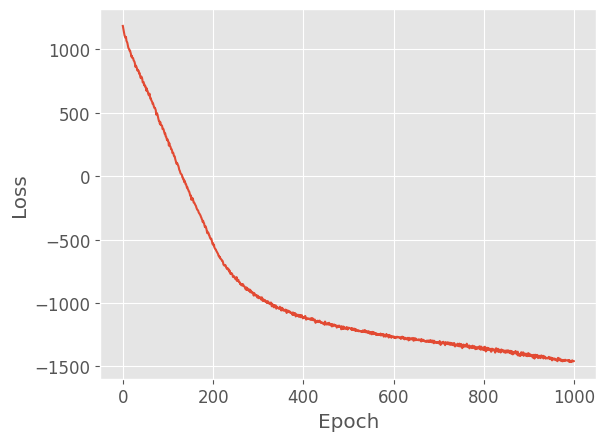

In [62]:
with plt.style.context("ggplot_perso.mplstyle"):
    fig, ax = plt.subplots()
    epochs = np.arange(num_epochs)
    ax.plot(epochs, losses)
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epoch")
    plt.show()

In [63]:
# predictive = Predictive(supervised_hmm_rnn, guide=guide, num_samples=num_samples_posterior)
# preds = predictive(supervised_classes, supervised_observations, emission_net)
# # preds

In [64]:
# Prepare "classes" input for the model: mark all labels unknown with -1
# T = observations_new.shape[0]
T = supervised_observations.shape[0]
masked_classes = torch.full((T,), -1, dtype=torch.long)  # means "unobserved"
masked_classes.shape, masked_classes

(torch.Size([220]),
 tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        

In [65]:
# Predictive configured to run the guide (approx posterior) and return latent samples.
# pass guide as `guide` to Predictive so it uses the guide instead of model's prior
predictive = Predictive(
    supervised_hmm_rnn,  # the model
    guide=guide,  # the trained AutoGuide
    num_samples=num_samples_posterior,  # increase for more stable marginals
    return_sites=None,  # or list of sites to return, e.g., ["class_id_0", ...]
)
samples = predictive(
    classes=masked_classes,
    observations=supervised_observations,
    emission_net=emission_net,
)
# samples = predictive(classes=supervised_classes, observations=supervised_observations, emission_net=emission_net)
# samples is a dict of site-name -> tensor of shape (num_samples, ...)
# look for keys like "class_id_0", "class_id_1", ... depending on your model

# aggregate per-timestep
state_keys = [k for k in samples.keys() if k.startswith("class_id_")]
state_keys = sorted(state_keys, key=lambda s: int(s.split("_")[-1]))  # keep time order

# stack into (num_samples, T)
stacked = torch.stack([samples[k] for k in state_keys], dim=1)  # shape (num_samples, T)

# majority vote (marginal MAP per timestep)
mode_per_t, _ = torch.mode(stacked, dim=0)  # shape (T,)
most_likely_states = mode_per_t.squeeze()
assert most_likely_states.shape == masked_classes.shape

In [66]:
most_likely_states.shape

torch.Size([220])

In [67]:
print(f"True classes:\n{supervised_classes}")
print(f"Predicted hidden states:\n{most_likely_states}")
print(f"State distribution: {torch.bincount(most_likely_states)}")

True classes:
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1])
Predicted hidden states:
tensor([0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1

### Metrics & visualization

In [68]:
accu = accuracy_score(y_true=supervised_classes, y_pred=most_likely_states)
f1 = f1_score(y_true=supervised_classes, y_pred=most_likely_states, average="macro")
print(f"Accuracy: {accu}")
print(f"F1: {f1}")

Accuracy: 0.509090909090909
F1: 0.48004201680672265


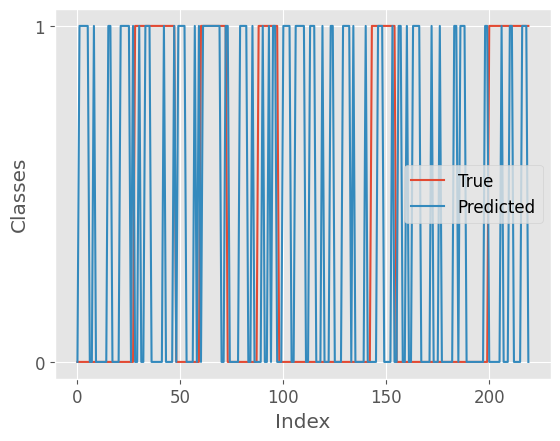

In [69]:
with plt.style.context("ggplot_perso.mplstyle"):
    fig, ax = plt.subplots()  # figsize=(11, 7))
    ax.plot(supervised_classes, label="True")
    ax.plot(most_likely_states, label="Predicted")
    ax.legend(loc="best")
    ax.set_ylabel("Classes")
    ax.set_xlabel("Index")
    ax.yaxis.set_major_locator(mpl.ticker.FixedLocator(supervised_classes.unique()))
    ax.yaxis.set_major_formatter(
        mpl.ticker.FixedFormatter(
            [str(elem.item()) for elem in supervised_classes.unique()]
        )
    )
    plt.show()

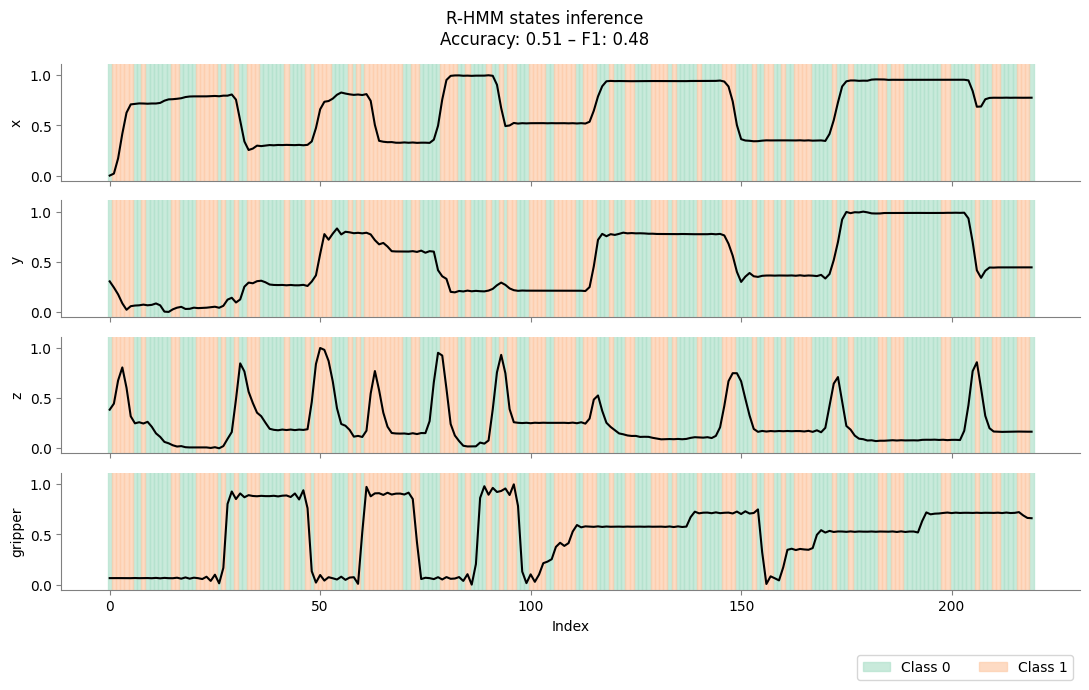

In [70]:
fig, axes = plt.subplots(
    nrows=supervised_observations.shape[1], ncols=1, sharex=True, figsize=(11, 7)
)
cmap = mpl.colormaps.get("Pastel2").colors
df_labels = list(traj.drop(columns=["timestamp"]).keys())
ts = torch.arange(end=supervised_observations.shape[0])
for idx, ax in enumerate(axes):
    ax.plot(supervised_observations[:, idx], "k")  # , color=cmap[0])
    ax.set_ylabel(df_labels[idx])
    ax.spines[["right", "top"]].set_visible(False)
    ax.tick_params(color="gray")
    for spine in ax.spines.values():
        spine.set_edgecolor("gray")

    # fill_min = np.min([traj.x.min(), traj.y.min(), traj.z.min(), traj.gripper.min()])
    # fill_max = np.max([traj.x.max(), traj.y.max(), traj.z.max(), traj.gripper.max()])
    #     ax.fill_between(
    #         x=xs,
    #         y1=fill_min - 1,
    #         y2=fill_max + 1,
    #         color=cmap[sect_i],
    #         alpha=0.5,
    #         transform=ax.get_xaxis_transform(),
    #         label=sect_key,
    #     )
    y_low, y_high = ax.get_ylim()
    y_mid = torch.tensor([y_low, y_high], device=device).mean().item()
    # y_height = 0.05 * (y_high - y_low)
    y_height = y_high - y_low
    for jdx, class_id in enumerate(supervised_classes.unique()):
        xs = ts[most_likely_states == class_id]
        for zdx, xi in enumerate(xs):
            if zdx == 0:
                ax.fill_between(
                    # [x - 1, x],
                    [xi - 0.5, xi + 0.5],
                    [y_mid - y_height] * 2,
                    [y_mid + y_height] * 2,
                    alpha=0.7,
                    color=cmap[jdx],
                    label=f"Class {class_id}",
                )
            else:
                ax.fill_between(
                    # [x - 1, x],
                    [xi - 0.5, xi + 0.5],
                    [y_mid - y_height] * 2,
                    [y_mid + y_height] * 2,
                    alpha=0.7,
                    color=cmap[jdx],
                )
    ax.set_ylim(bottom=y_low * 1.01, top=y_height * 1.01)
axes[-1].set_xlabel("Index")
# axes[0].legend(bbox_to_anchor=(1.0, 1.02))
# if what_segments == "LowerLevel":
#     bbox_to_anchor = (0.61, -0.6)
# elif what_segments == "HigherLevel":
#     bbox_to_anchor = (0.8, -0.6)
#     bbox_to_anchor = (1, -0.5)
axes[-1].legend(bbox_to_anchor=(1, -0.5), ncol=len(supervised_classes.unique()))
fig.suptitle(f"R-HMM states inference\nAccuracy: {accu:3.2f} – F1: {f1:3.2f}")
# fig.autofmt_xdate()
fig.tight_layout()
plt.show()

### Validation

In [71]:
def fit_predict_rhmm(X_train, y_train, X_test):
    # --- Data ---
    supervised_classes = torch.tensor(y_train, dtype=int, device=device)
    supervised_observations = torch.tensor(X_train, dtype=torch.float32, device=device)
    supervised_obs_test = torch.tensor(X_test, dtype=torch.float32, device=device)

    # --- Fit ---
    # Initialize the RNN
    emission_net = RNNEmissionModel(
        num_hidden_states=num_hidden_states,
        num_features=num_features,
        rnn_hidden_size=rnn_hidden_size,
    )

    optimizer = pyro.optim.Adam(
        {"lr": learning_rate, "weight_decay": 1e-4}, {"clip_norm": 10.0}
    )  # L2 regularization
    guide = autoguide.AutoNormal(supervised_hmm_rnn)
    svi = pyro.infer.SVI(
        supervised_hmm_rnn, guide, optimizer, loss=pyro.infer.Trace_ELBO()
    )
    pyro.clear_param_store()

    progress_bar = trange(num_epochs)
    losses = []
    for epoch in progress_bar:
        loss = svi.step(supervised_classes, supervised_observations, emission_net)
        losses.append(loss)
        progress_bar.set_postfix(loss=f"{loss / supervised_classes.shape[0]:.3f}")

    # --- Predict ---
    # Prepare "classes" input for the model: mark all labels unknown with -1
    T = supervised_obs_test.shape[0]
    masked_classes = torch.full((T,), -1, dtype=torch.long)  # means "unobserved"

    # Predictive configured to run the guide (approx posterior) and return latent samples.
    # pass guide as `guide` to Predictive so it uses the guide instead of model's prior
    predictive = Predictive(
        supervised_hmm_rnn,  # the model
        guide=guide,  # the trained AutoGuide
        num_samples=num_samples_posterior,  # increase for more stable marginals
        return_sites=None,  # or list of sites to return, e.g., ["class_id_0", ...]
    )
    samples = predictive(
        classes=masked_classes,
        observations=supervised_obs_test,
        emission_net=emission_net,
    )  # dict of site-name -> tensor of shape (num_samples, ...)

    # aggregate per-timestep
    state_keys = [k for k in samples.keys() if k.startswith("class_id_")]
    state_keys = sorted(
        state_keys, key=lambda s: int(s.split("_")[-1])
    )  # keep time order

    # stack into (num_samples, T)
    stacked = torch.stack(
        [samples[k] for k in state_keys], dim=1
    )  # shape (num_samples, T)

    # majority vote (marginal MAP per timestep)
    mode_per_t, _ = torch.mode(stacked, dim=0)  # shape (T,)
    most_likely_states = mode_per_t.squeeze()
    assert most_likely_states.shape == masked_classes.shape

    return most_likely_states

In [72]:
n_splits = 2
tscv = TimeSeriesSplit(n_splits=n_splits)
for idx, (train_index, test_index) in enumerate(tscv.split(X_down_scaled)):
    print(f"----- Split {idx + 1}/{n_splits} -----")
    X_train = X_down_scaled[train_index]
    X_test = X_down_scaled[test_index]
    y_train = y_down[train_index]
    y_test = y_down[test_index]

    y_pred = fit_predict_rhmm(X_train=X_train, y_train=y_train, X_test=X_test)

    # Metrics
    f1 = f1_score(y_test, y_pred, average="macro")
    print(f"F1: {f1}")
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")  #:.2f}")
    # logloss_metric = log_loss(y_true=y_test, y_pred=y_pred, labels=np.arange(len(labels)))
    # print(f"Log Loss for 'multi:softprob': {logloss_metric}")#:.4f}")

----- Split 1/2 -----


  0%|          | 0/1000 [00:00<?, ?it/s]

F1: 0.5019493177387914
Accuracy: 0.6164383561643836
----- Split 2/2 -----


  0%|          | 0/1000 [00:00<?, ?it/s]

F1: 0.4623567921440262
Accuracy: 0.5068493150684932
